In [154]:
%matplotlib inline
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10, 6)

import statsmodels.api as sm
# sm.tsa.filters.hpfilter()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima.model import ARIMA
import arch

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

---

In [43]:
!cat yen.csv | head -n2

Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
1976-08-02,3398.0,3401.0,3398.0,3401.0,,3401.0,2.0,1.0
cat: stdout: Broken pipe


In [44]:
yen_futures = pd.read_csv('yen.csv', index_col='Date', parse_dates=True, infer_datetime_format=True)#.loc['1990-01-01':,:]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [45]:
yen_futures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10902 entries, 1976-08-02 to 2019-10-15
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        10902 non-null  float64
 1   High                        10902 non-null  float64
 2   Low                         10902 non-null  float64
 3   Last                        10902 non-null  float64
 4   Change                      1415 non-null   float64
 5   Settle                      10902 non-null  float64
 6   Volume                      10902 non-null  float64
 7   Previous Day Open Interest  10902 non-null  float64
dtypes: float64(8)
memory usage: 766.5 KB


In [46]:
(yen_futures.describe()/1e3).round(3)

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
count,10.902,10.902,10.902,10.902,1.415,10.902,10.902,10.902
mean,7.961,7.987,7.936,7.961,0.035,7.961,40.537,89.016
std,2.355,2.363,2.348,2.355,0.034,2.355,57.922,70.386
min,3.343,3.346,3.343,3.346,0.000,3.346,0.000,0.000
25%,6.550,6.576,6.539,6.562,0.012,6.562,5.389,33.835
50%,8.414,8.444,8.384,8.416,0.027,8.416,15.796,72.449
75%,9.396,9.425,9.362,9.394,0.050,9.394,42.992,139.202
max,13.217,13.264,13.167,13.210,0.330,13.210,857.206,347.980


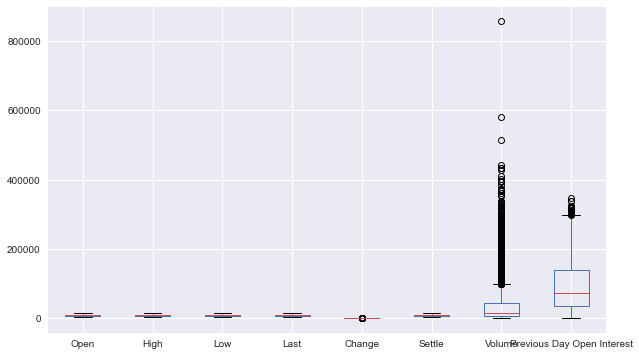

In [48]:
yen_futures.boxplot();

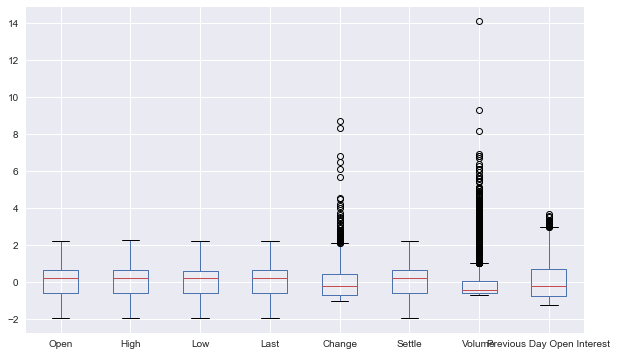

In [47]:
((yen_futures - yen_futures.mean()) / yen_futures.std()).boxplot();

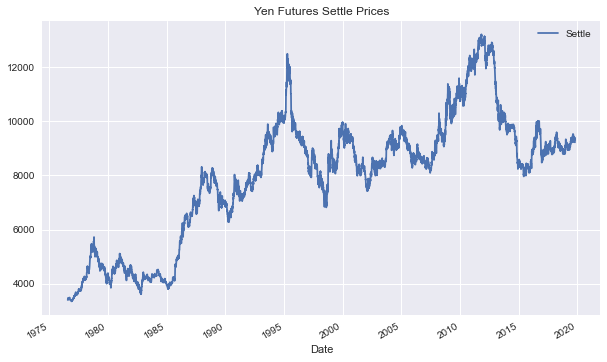

In [54]:
yen_futures[['Settle']].plot(title='Yen Futures Settle Prices');

In [110]:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])
futures_decomp = yen_futures[['Settle']].copy()
futures_decomp['noise'] = ts_noise
futures_decomp['trend'] = ts_trend
futures_decomp.head()

,Settle,noise,trend
Date,,,
1976-08-02,3401.0,10.174688,3390.825312
1976-08-03,3401.0,6.238556,3394.761444
1976-08-04,3401.0,2.296065,3398.703935
1976-08-05,3401.0,-1.663044,3402.663044
1976-08-06,3401.0,-5.650464,3406.650464


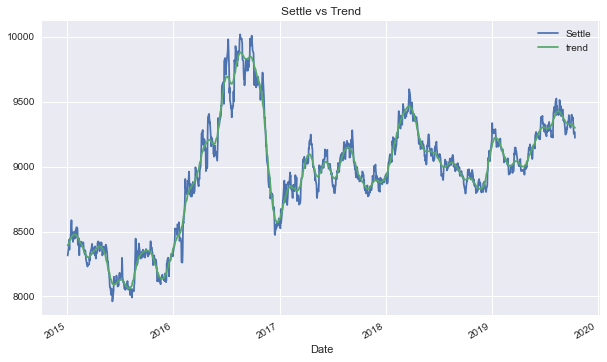

In [114]:
futures_decomp[['Settle', 'trend']]['2015-01-01':].plot(title='Settle vs Trend');

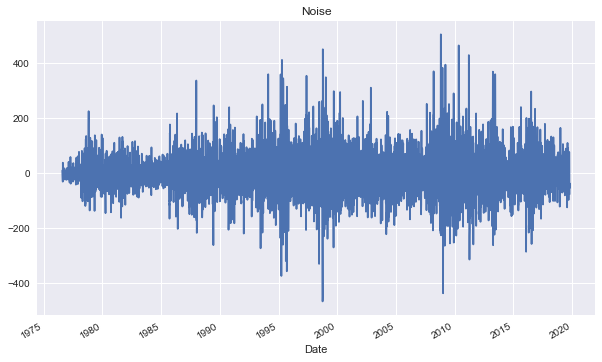

In [115]:
ts_noise.plot(title='Noise');

In [128]:
returns = yen_futures.loc['01-01-1990':,:][['Settle']].pct_change() * 100
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [129]:
model = sm.tsa.ARMA(returns, order=(2, 1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sun, 25 Apr 2021   AIC                          15798.142
Time:                        19:20:33   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.Settle    -0.3061      1.277     -0.240      0.811      -2.810       2.198
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2945      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3367           +0.0000j            3.3367            0.5000
AR.2         -157.2756           +0.0000j          157.2756            0.5000
MA.1           -3.3957           +0.0000j            3.3957            0.5000
-----------------------------------------------------------------------------
"""

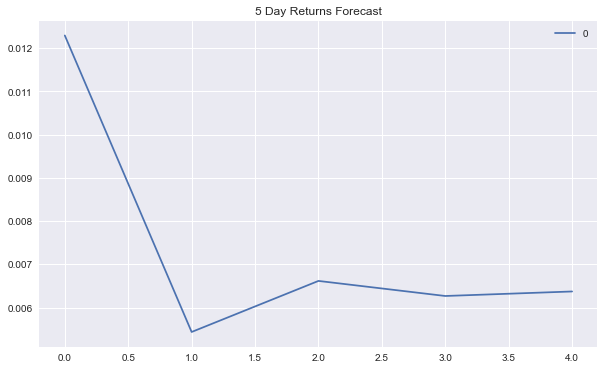

In [130]:
pd.DataFrame(results.forecast(steps=5)[0]).plot(title='5 Day Returns Forecast');

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                10901
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -59614.572
Method:                       css-mle   S.D. of innovations             57.385
Date:                Sun, 25 Apr 2021   AIC                         119245.144
Time:                        19:28:31   BIC                         119303.517
Sample:                             1   HQIC                        119264.818
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5345      0.526      1.017      0.309      -0.496       1.565
ar.L1.D.Settle     0.2259      0.595      0.380      0.704      -0.941       1.392
ar.L2.D.Settle    -0.0026      0.012     -0.223      0.824      -0.025       0.020
ar.L3.D.Settle    -0.0061      0.010     -0.594      0.552      -0.026       0.014
ar.L4.D.Settle    -0.0133      0.011     -1.244      0.214      -0.034       0.008
ar.L5.D.Settle    -0.0024      0.014     -0.178      0.859      -0.029       0.024
ma.L1.D.Settle    -0.2363      0.595     -0.397      0.691      -1.403       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9130           -1.4192j            2.3820           -0.1016
AR.2            1.9130           +1.4192j            2.3820            0.1016
AR.3           -1.7091           -3.0613j            3.5061           -0.3310
AR.4           -1.7091           +3.0613j            3.5061            0.3310
AR.5           -5.8700           -0.0000j            5.8700           -0.5000
MA.1            4.2311           +0.0000j            4.2311            0.0000
-----------------------------------------------------------------------------
"""

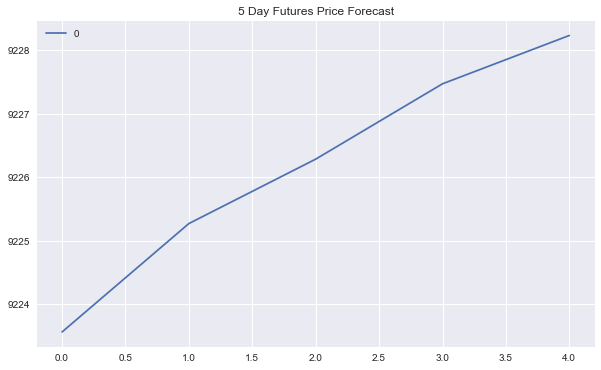

In [134]:
model = ARIMA(yen_futures[['Settle']], order=(5, 1, 1))
results = model.fit()
display(results.summary())
pd.DataFrame(results.forecast(steps=5)[0]).plot(title='5 Day Futures Price Forecast');

In [135]:
model = arch.arch_model(returns, mean='Zero', vol='GARCH', p=2, q=1)
results = model.fit()
results.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 87510785.45716049
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8220.92713535338
Iteration:      3,   Func. Count:     22,   Neg. LLF: 7487.706274033166
Iteration:      4,   Func. Count:     28,   Neg. LLF: 7505.857088437436
Iteration:      5,   Func. Count:     34,   Neg. LLF: 7479.053903182994
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7895.885813879309
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7462.418448377437
Iteration:      8,   Func. Count:     52,   Neg. LLF: 7462.214153928055
Iteration:      9,   Func. Count:     57,   Neg. LLF: 7462.021586253446
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7461.935968239088
Iteration:     11,   Func. Count:     67,   Neg. LLF: 7461.927898370626
Iteration:     12,   Func. Count:     72,   Neg. LLF: 7461.927643544426
Iteration:     13,   Func. Count:     77,   Neg. LLF: 7461.927640079675
Iteration:     14,   Func. Count:     81,   Neg. LLF: 7461.927640

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Sun, Apr 25 2021   Df Residuals:                     7514
Time:                        19:28:39   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [136]:
last_day = returns.index.max().strftime('%Y-%m-%d')
forecast_horizon = 5
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [137]:
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


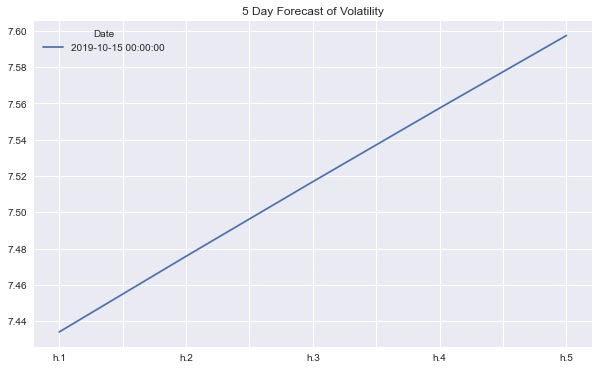

In [138]:
final.plot(title='5 Day Forecast of Volatility');

---

Linear Regression

In [144]:
yen_futures = pd.read_csv('yen.csv', index_col='Date', parse_dates=True, infer_datetime_format=True)
yen_futures = yen_futures.loc['1990-01-01':, :]
yen_futures['Return'] = yen_futures['Settle'].pct_change() * 100
yen_futures = yen_futures.replace(-np.inf, np.nan).dropna()
yen_futures['Lagged_Return'] = yen_futures['Return'].shift()
yen_futures = yen_futures.dropna()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970,0.020502


In [147]:
train = yen_futures[:'2017']
test = yen_futures['2018':]
X_train = train['Lagged_Return'].to_frame()
y_train = train['Return']
X_test = test['Lagged_Return'].to_frame()
y_test = test['Return']
display(
    train.shape,
    test.shape,
    X_train.shape,
    y_train.shape,
    X_test.shape,
    y_test.shape,
)

(966, 10)

(448, 10)

(966, 1)

(966,)

(448, 1)

(448,)

In [156]:
model = LinearRegression()
model = model.fit(X_train, y_train)
model.get_params()
y_pred = model.predict(X_test)

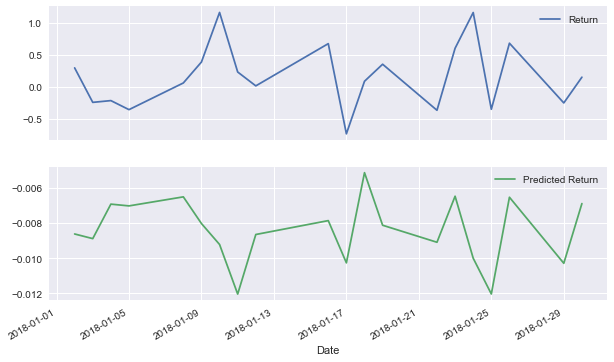

In [157]:
out_of_sample_results = y_test.to_frame()
out_of_sample_results['Predicted Return'] = y_pred
out_of_sample_results[:20].plot(subplots=True);

In [160]:
out_of_sample_mse = mean_squared_error(out_of_sample_results['Return'], out_of_sample_results['Predicted Return'])
out_of_sample_rmse = np.sqrt(out_of_sample_mse)
display(
    out_of_sample_mse,
    out_of_sample_rmse,
)

0.17262635470120388

0.4154832784856737

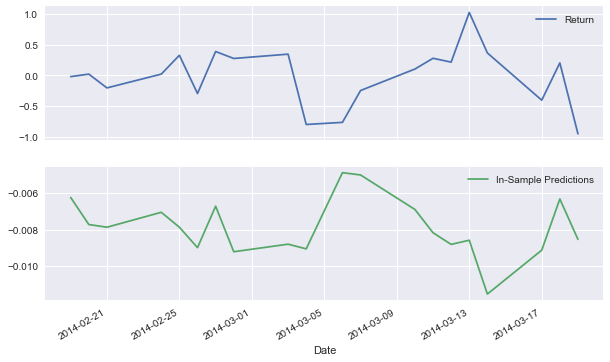

In [161]:
in_sample_results = y_train.to_frame()
in_sample_results['In-Sample Predictions'] = model.predict(X_train)
in_sample_results[:20].plot(subplots=True);

In [159]:
in_sample_mse = mean_squared_error(in_sample_results['Return'], in_sample_results['In-Sample Predictions'])
in_sample_rmse = np.sqrt(in_sample_mse)
display(
    in_sample_mse,
    in_sample_rmse,
)

0.35565249959422596

0.5963660785073426

---